# Procesamiento Digital de Señales <img src="./logo_UTN.svg" align="right" width="150"/>
## Alumno: Emanuel Olay
### TP de Aplicación

## 1. Introducción
> ### ¿Por qué es útil?
El ritmo respiratorio (**RR**) es una medición importante para el diagnostico de la salud, ya que es un parametro muy sensible respecto del deterioro del estado de salud del paciente.<br>
Si la medición diera por fuera de los limites esperables para la edad y condicion del paciente esto podria ayudar a identificar signos de neumonia, septicemia, hipercarbia y embolias pulmonares.Por ejemplo, un ritmo respiratorio elevado puede predecir un paro cardiaco, a su vez puede indicar disfuncionalidades respiratorias.<br>
Y como consecuencia, el ritmo respiratorio se mide cada 4 a 6 horas en pacientes hospitalizados de gravedad.<br>
> ### Aplicación en la vida cotidiana
El ritmo respiratorio se suele medir de forma manual mediante el conteo de los movimientos de inhalación y exhalación de la caja toráxica (fuera de cuidados intesivos). Este es un procedimiento arduo, extenso e impreciso.<br>
Esto se podria solucionar implementando algoritmos que estimen el ritmo respiratorio por medio del analisis de parámetros no invasivos, como por ejemplo el ritmo cardíaco.<br>
La estimación respiratoria desde el electrocardiograma (**ECG**) se podría realizar mediante dispositivos cotidianos, como por ejemplo, los smart watches que hoy en día, en su mayoria, perciben los latidos. 


*[1] van Gent P, Farah H, van Nes N, van Arem B. HeartPy: A novel heart rate algorithm for the analysis of noisy signals. Transportation research part F: traffic psychology and behaviour. 2019 Oct 1;66:368-78.<br>
[2] S. Khreis, D. Ge, H. A. Rahman and G. Carrault, "Breathing Rate Estimation Using Kalman Smoother With Electrocardiogram and Photoplethysmogram," in IEEE Transactions on Biomedical Engineering, vol. 67, no. 3, pp. 893-904, March 2020, doi: 10.1109/TBME.2019.2923448.<br>
Mi github con el codigo: https://github.com/EmaOlay/PDS2021*


In [15]:
#%% Imports

import warnings
warnings.filterwarnings('ignore')
from funciones_final import *

from pandas import DataFrame
from IPython.display import HTML
plt.close('all')

width=16
height=10
plt.rcParams['figure.figsize'] = [width, height]

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

# Condiciones de las mediciones
> Para la aplicación del algoritmo se tomaron mediciones conjuntas de ECG y respiración, durante una hora sobre pacientes en reposo escuchando musica clásica.<br>
Con un sampling $F_s=5Khz$ , por la naturaleza de la señal, se tomaron $50K$ muestras que equivaldrian a 10 segundos con el objetivo de englobar varios ciclos de inhalación y exhalación.

In [2]:
# %%Variables
###################################################
#Por el readme.txt interpreto que se sampleo a 5Khz
fs= 5000 #Hz
path2 = r"E:\Facultad\PDS\combined-measurement-of-ecg-breathing-and-seismocardiograms-1.0.0\m001"
record2 = wfdb.rdrecord(path2)
###Para 5Khz, 50000 son unos 10 segundos que nos darian unas 3-4 respiraciones
muestras = 50000

ecg = record2.p_signal[::,1]
resp_ref = record2.p_signal[::,2]

## 2. Metodologia
> "Los algoritmos de estimación respiratoria pueden abarcar hasta 5 pasos.
El rol de cada uno de los pasos son los siguientes:<br>
**1) Extracción de la señal respiratoria(s)**: consiste en extraer una o mas señales dominadas por una modulación respiratoria.<br>2) Fusión de las señales respiratorias: multiples señales respiratorias pueden ser fusionadas para resultar en una señal respiratoria única(opcional).<br>3) Estimación del RR(s): consiste en estimar el RR a partir de una ventana de la señal respiratoria.<br>4) Fusionar RR(s): múltiples estimaciones de RR pueden ser fusionadas para obtener una estimación final(opcional).<br>5) Evaluación de calidad: se hace para rechazar o mitigar posibles impresiciones en las estimaciones(opcional)."
### Extracción de la señal respiratoria(s)
> Hay dos metodos principales para la extracción de la señal respiratoria:<br> * *Tecnicas basadas en filtros<br> * Tecnicas basadas en las caracteristicas morfológicas* <br> En ambos metodos se utilizan los siguientes pasos: <br>1. Extracción en base a las caracteristicas morfológicas desde un ECG, previamente filtrado, procedemos a una detección de los picos R del complejo QRS y luego interpolamos para generar una señal de respiración estimada.<br>2. Eliminación de frecuencias muy bajas, esto es esencialmente para no tener interferencia de elementos que no puedan ser respiraciones. Por ejemplo, no es esperable respirar menos de 4 veces por minuto.<br>3. Eliminación de muy altas frecuencias, nuevamente no es esperable respirar más de 65 veces por minuto.<br>4. Estimación del RR, utilizando la transformación rapida de Fourier(**FFT**) identificamos el componente frecuencial relacionado al RR.<br>5. Revisión de los resultados: haciendo uso de un análisis espectral con el periodograma de Welch, podemos hallar el ancho de banda de la señal, de forma tal qué nuestros resultados, al menos queden acotados en esa banda.

*Charlton, P.H., Birrenkott, D.A., Bonnici, T., Pimentel, M.A., Johnson, A.E., Alastruey, J., Tarassenko, L., Watkinson, P.J., Beale, R. and Clifton, D.A., 2017. Breathing rate estimation from the electrocardiogram and photoplethysmogram: A review. IEEE reviews in biomedical engineering, 11, pp.2-20.*

## Demostración de la interpolación

> Armamos una señal extraida del ECG a partir de la interpolación de los picos del complejo QRS.<br>
Esto es un método que parte de la morfología y las características intrínsecas de la señal del ECG. 

In [3]:
#%%itero mi funcion para el histograma

#Total de iteraciones completas que puedo hacer sobre 1 ecg largo
iteraciones=(int(ecg.size/muestras))
#Para probar uso 10
# iteraciones=1
# Creo la matriz de resultados
w, h = 3, iteraciones
Matriz = np.zeros((h, w))


for i in range(iteraciones):
      ecg_recorte = ecg[i*(muestras):(i+1)*muestras]
      resp_recorte = resp_ref[i*(muestras):(i+1)*muestras]
      Matriz[i,:]=calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Nada')

(0.33, 0.38, 0.24)

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


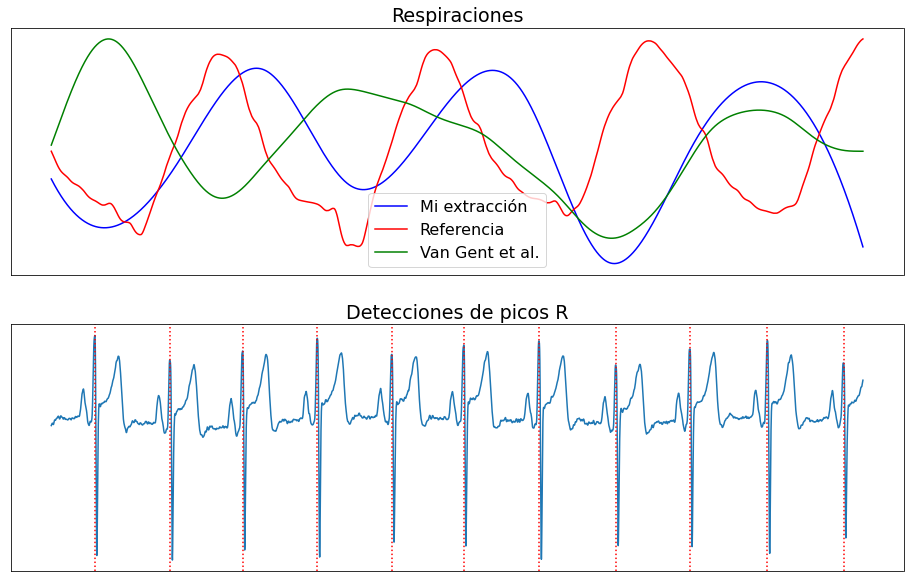

In [4]:
#%% Pruebo mi funcion
ecg_recorte = ecg[0:muestras]
resp_recorte = resp_ref[0:muestras]
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Interpolacion')

## Filtramos la señal extraida
> La interpolación en general es muy suave por la cantidad de puntos que tenemos.De todas formas graficamos las salidas de los filtros para demostrar que no afectan a la respiración.<br>

Los filtros en cuestión son los siguientes:<br>
- un pasa altos para eliminar la contínua y frecuencias respiratorias que no consideramos posibles por lo bajas que son(menores a 4 respiraciones por minuto).
- un pasa bajos para eliminar altas frecuencias que no consideremos posibles(mayores a 64 respiraciones por minuto).
- un notch que quite el ruido de linea de 50 Hz.

*Estas decisiones fueron basadas en W. Karlen et al., “Respiratory rate assessment from photoplethysmographic imaging,” in Proc. Conf. Proc. Eng. Med. Biol. Soc., 2014,
pp. 5397–5400. [Online]. Available: http://doi.org/10.1109/EMBC.2014.
6944846*

(0.33, 0.38, 0.24)

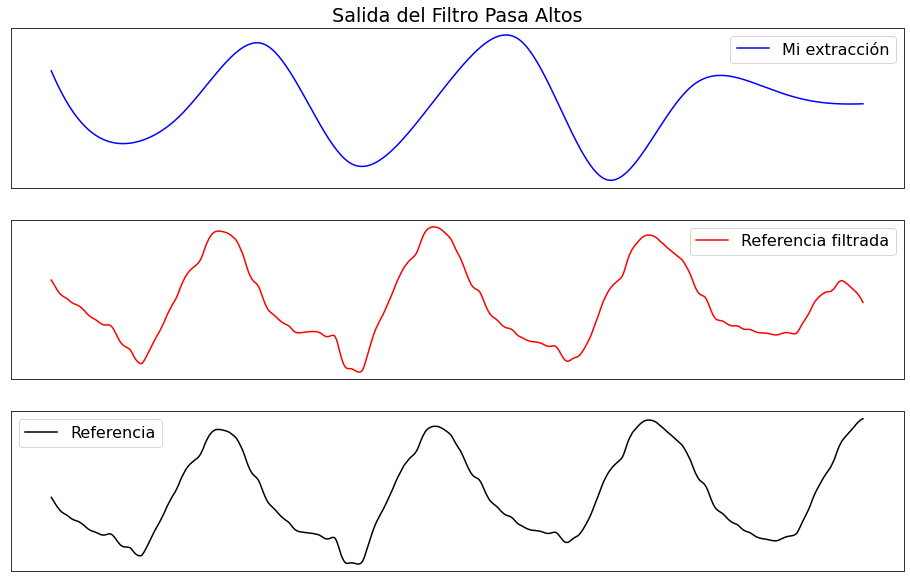

In [16]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida HP')

La salida del LP es despues de filtrar por el HP


(0.33, 0.38, 0.24)

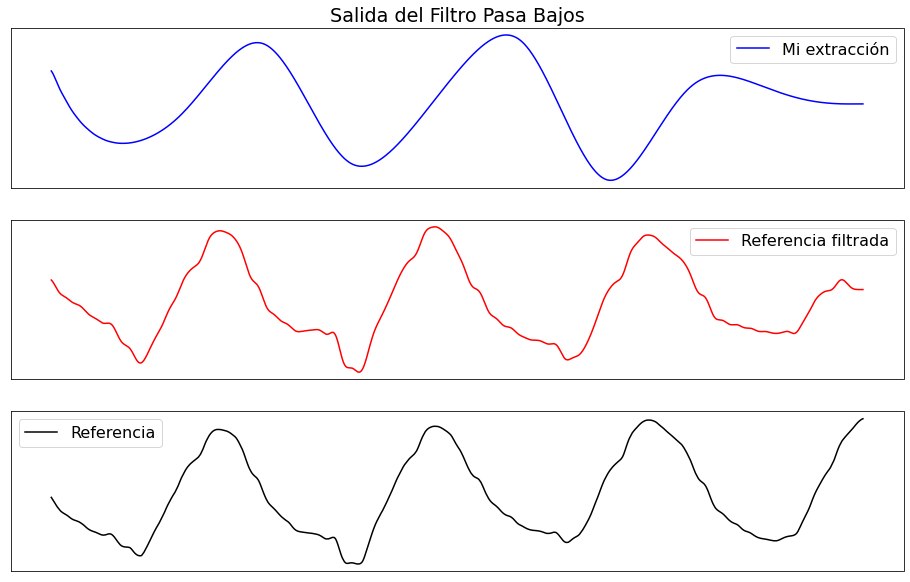

In [6]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida LP')

(0.33, 0.38, 0.24)

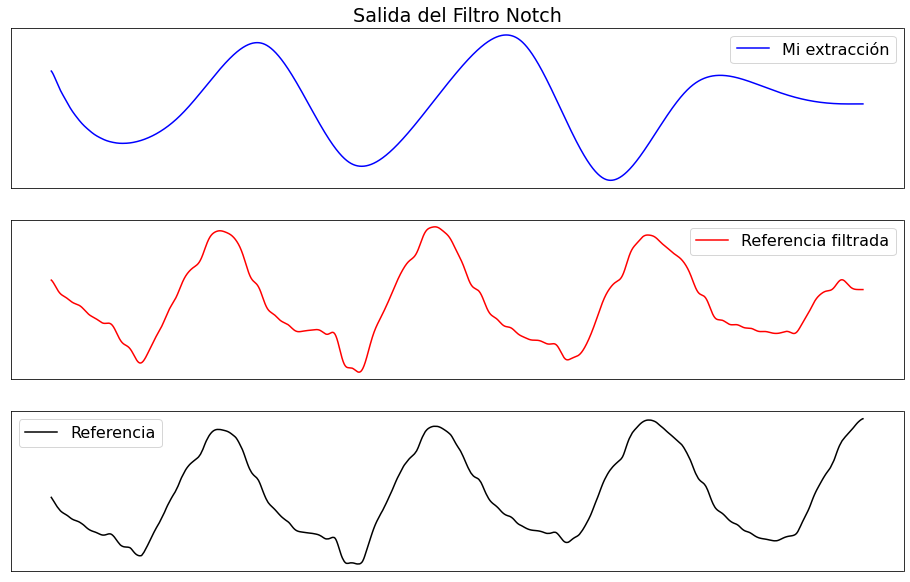

In [17]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='Salida Notch')

# Demostración del Ancho de Banda
A continuación vamos a mostrar por el metodo del periodograma de Welch en qué ancho de banda se encuentra el 95% de la energía, para constatar que la estimación final, se encuentre al menos, dentro de ese ancho de banda.<br>

(0.33, 0.38, 0.24)

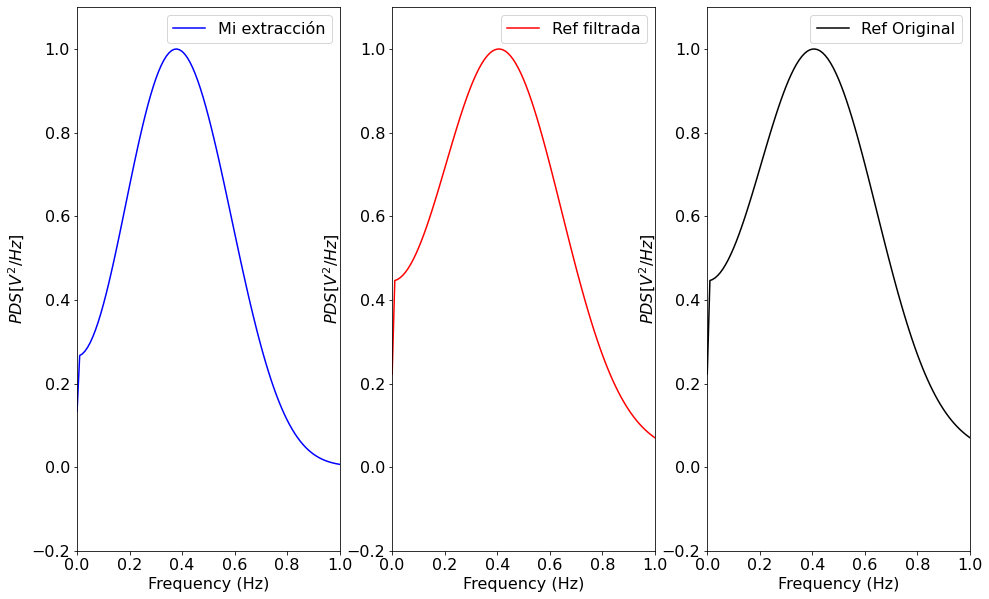

In [18]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='BW_1')

(0.33, 0.38, 0.24)

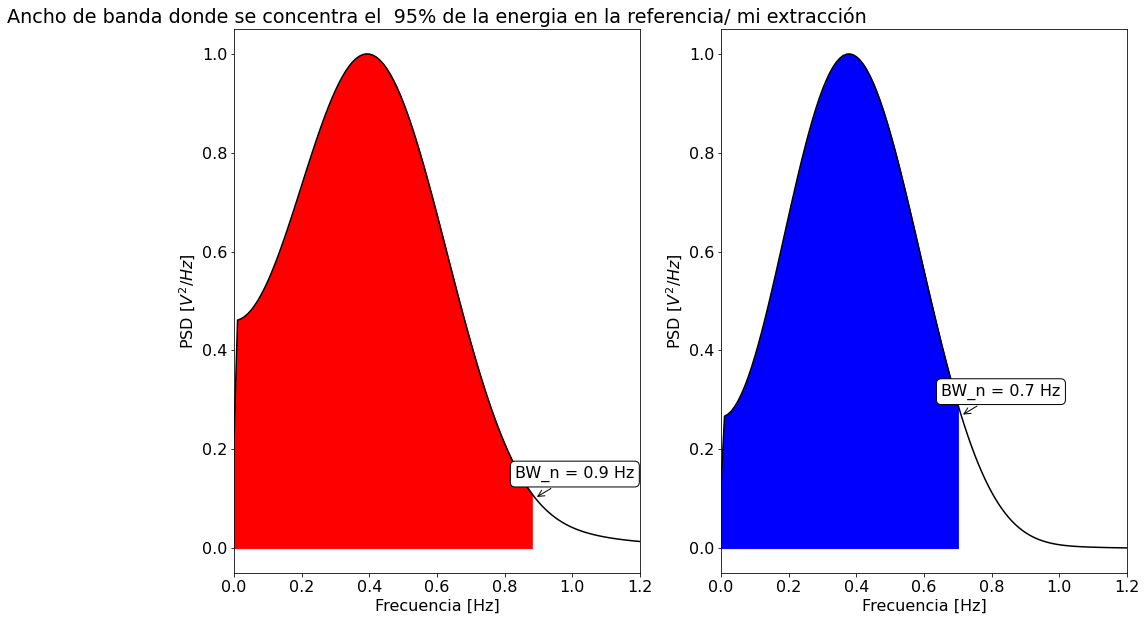

In [9]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='BW_2')

# Aproximación de la frecuencia respiratoria
> A partir de lo expuesto hasta acá, es evidente que nuestra información está muy concentrada en banda y es aceptable considerar que la misma es única en el pico de frecuencia que expondremos a continuación.<br>

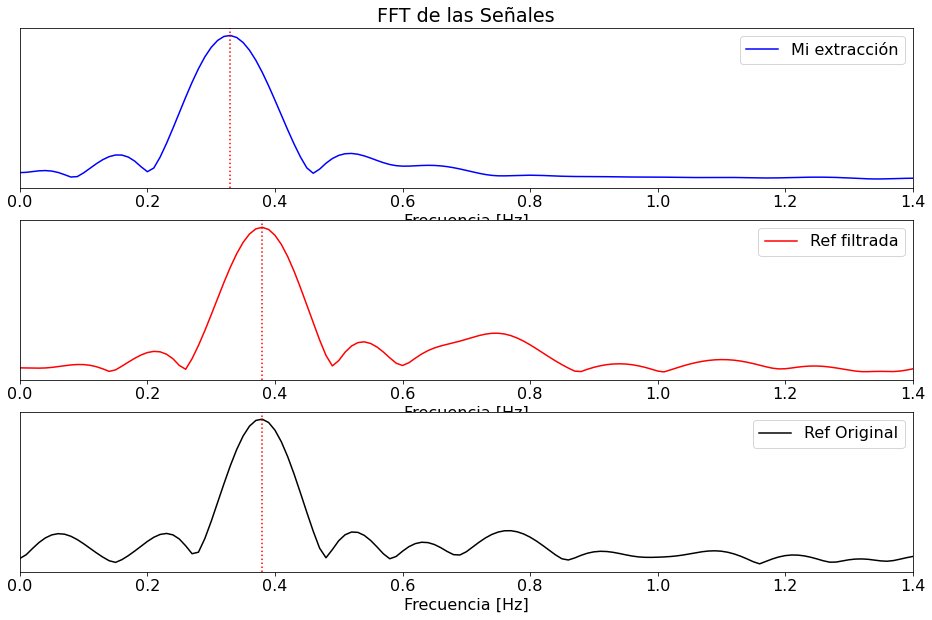

(0.33, 0.38, 0.24)

In [10]:
calculo_ritmo_respiratorio(ecg_recorte,resp_recorte,fs=fs,p_print='FFT')

# Repetimos el cálculo de la frecuencia respiratoria
> El cálculo anterior lo iteramos a lo largo de unas 250 extracciones y graficamos en histogramas sus resultados.<br>

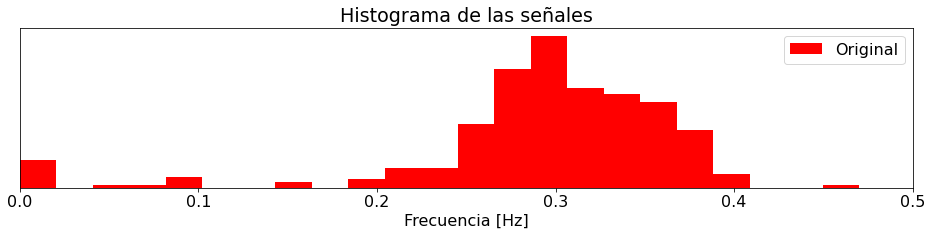

In [11]:
#%% Armo el histograma con la matriz
# Matriz[:,1] es la original yMatriz[:,0] es la mia
plt.figure(11)

plt.subplot(3,1,1)
plt.hist(Matriz[:,1],bins='auto',label='Original', color= 'Red')
plt.xlim(0,.5)
plt.title('Histograma de las señales')
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()


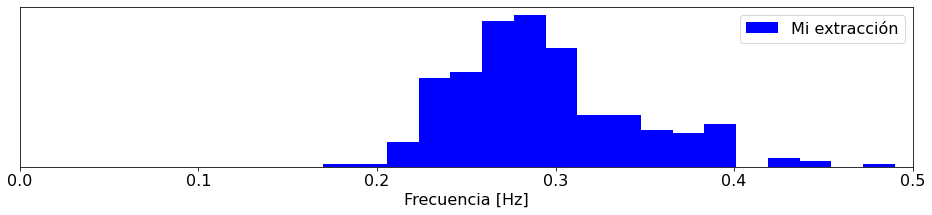

In [19]:
#%% Armo el histograma con la matriz
plt.subplot(3,1,2)
plt.hist(Matriz[:,0],bins='auto',label='Mi extracción', color= 'Blue')
plt.xlim(0,.5)
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()


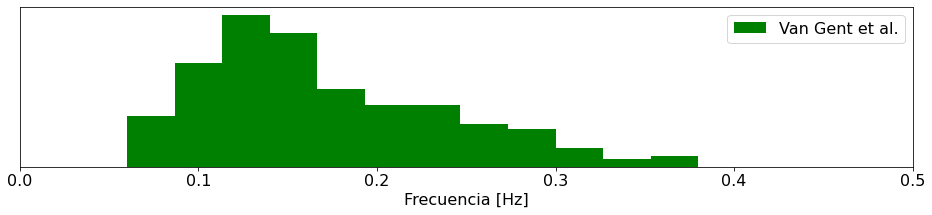

In [20]:
#%%
plt.subplot(3,1,3)
plt.hist(Matriz[:,2],bins='auto',label='Van Gent et al.', color= 'Green')
plt.xlim(0,.5)
plt.xlabel('Frecuencia [Hz]')
#Con estas dos sentencias escondo los ticks de los ejes
plt.gca().axes.get_yaxis().set_visible(False)
plt.legend()
plt.show()

# Cálculo del sesgo y la varianza
> Comparación del sesgo y la varianza de mi estimación respecto de la estimación que se hace en el neurokit.<br>

In [14]:
#%%
#######################
#Calculo de sesgo y varianza
#######################

# media muestral: mu_a = 1/M.SUM{â_j} de 0 a M-1

E_extraccion = np.mean(Matriz[:,0])
E_original = np.mean(Matriz[:,1])
E_van = np.mean(Matriz[:,2])

#Sesgo: s = mu - a0

s_extraccion = E_extraccion - E_original
s_van = E_van - E_original

#Varianza: Var(x)=E[(X-mu)**2]

var_extraccion = np.var(Matriz[:,0])
var_van = np.var(Matriz[:,2])


# Muestro los datos

data = [[s_extraccion, var_extraccion],
        [s_van, var_van]
        ]

df = DataFrame(data,columns=['$s_a$', '$v_a$'],
                index=[  
                        'Mi extracción',
                        'Van Gent et al.'
                      ])
HTML(df.to_html())

,$s_a$,$v_a$
Mi extracción,0.002359,0.002534
Van Gent et al.,-0.121690,0.004662


# Conclusiones y comentarios:
> La aproximación morfológica de la respiración es apropiada para el calculo de la frecuencia respiratoria, no asi para su visualización. En caso de querer aproximar su visualización se deberia aproximar con más puntos del ECG (en este trabajo se utilizó únicamente el punto R del complejo QRS), que aumentaría considerablemente el costo computacional.<br>
El filtrado de la frecuencia de línea en la extracción es innecesaria, ya que al tener pocos puntos para armar la señal, esta interferencia es despreciable.<br>
El metodo implementado en esta presentación es más eficaz ya que reducimos tanto el sesgo como la varianza respecto de la implementación del Neurokit.